## 1. Introduction
#### The dataset consists of annual mean PM2.5 concentrations in urban areas across various countries. In this notebook, I focused on handling missing values and outliers to prepare the data for further analysis. Ensuring clean data is crucial for accurate insights into air pollution levels.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
from scipy.stats import zscore
from matplotlib_venn import venn2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Import the dataset
df = pd.read_csv('../data/raw/WHO_PM25_urban_2022.csv')

In [3]:
# Show the data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9450 entries, 0 to 9449
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IndicatorCode               9450 non-null   object 
 1   Indicator                   9450 non-null   object 
 2   ValueType                   9450 non-null   object 
 3   ParentLocationCode          9450 non-null   object 
 4   ParentLocation              9450 non-null   object 
 5   Location type               9450 non-null   object 
 6   SpatialDimValueCode         9450 non-null   object 
 7   Location                    9450 non-null   object 
 8   Period type                 9450 non-null   object 
 9   Period                      9450 non-null   int64  
 10  IsLatestYear                9450 non-null   bool   
 11  Dim1 type                   9450 non-null   object 
 12  Dim1                        9450 non-null   object 
 13  Dim1ValueCode               9450 

In [4]:
# show part of the dataset
df.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,SDGPM25,Concentrations of fine particulate matter (PM2.5),text,AFR,Africa,Country,KEN,Kenya,Year,2019,...,NaN,NaN,6.29,NaN,13.74,10.01 [6.29-13.74],NaN,NaN,EN,2022-08-12T05:00:00.000Z
1,SDGPM25,Concentrations of fine particulate matter (PM2.5),text,AMR,Americas,Country,TTO,Trinidad and Tobago,Year,2019,...,NaN,NaN,7.44,NaN,12.55,10.02 [7.44-12.55],NaN,NaN,EN,2022-08-12T05:00:00.000Z
2,SDGPM25,Concentrations of fine particulate matter (PM2.5),text,EUR,Europe,Country,GBR,United Kingdom of Great Britain and Northern I...,Year,2019,...,NaN,NaN,9.73,NaN,10.39,10.06 [9.73-10.39],NaN,NaN,EN,2022-08-12T05:00:00.000Z
3,SDGPM25,Concentrations of fine particulate matter (PM2.5),text,AMR,Americas,Country,GRD,Grenada,Year,2019,...,NaN,NaN,7.07,NaN,13.20,10.08 [7.07-13.20],NaN,NaN,EN,2022-08-12T05:00:00.000Z
4,SDGPM25,Concentrations of fine particulate matter (PM2.5),text,AMR,Americas,Country,BRA,Brazil,Year,2019,...,NaN,NaN,8.23,NaN,12.46,10.09 [8.23-12.46],NaN,NaN,EN,2022-08-12T05:00:00.000Z


In [21]:
# modify the data type of DateModified
df['DateModified'] = pd.to_datetime(df['DateModified'], errors='coerce')

## 2. Missing Values and Duplicates

In [6]:
# Drop columns with all null values
df = df.dropna(axis=1, how='all')
    
# Remove duplicates
df = df.drop_duplicates()
    

## 3. Outliers
- #### To identify and remove outliers, I used two methods: the Interquartile Range (IQR) and Z-score.
- #### While both methods are effective for detecting outliers, I chose to use the IQR method for cleaning the data.
- #### The reason for this choice is that the IQR method is more robust to skewed data, which is the case of our data, whereas the Z-score method is more sensitive to extreme values in normally distributed data.

### 3.1 IQR

In [7]:
# Calculate the 25th (Q1) and 75th (Q3) percentiles
Q1 = df['FactValueNumeric'].quantile(0.25)
Q3 = df['FactValueNumeric'].quantile(0.75)

# Compute the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag outliers (1 for outliers, 0 for non-outliers)
df['outlier_IQR'] = ((df['FactValueNumeric'] < lower_bound) | 
                     (df['FactValueNumeric'] > upper_bound)).astype(int)

### 3.2 Z-score

In [8]:
# Calculate the Z-score of 'FactValueNumeric'
df['z_score'] = zscore(df['FactValueNumeric'])

# Flag outliers based on Z-score (1 for outliers, 0 for non-outliers)
# Outliers are defined as having an absolute Z-score greater than 3
df['outlier_z'] = (df['z_score'].abs() > 3).astype(int)

### 3.3 IQR vs Z-score

In [9]:
# Print the number of IQR-based and Z-score-based outliers 
print("IQR Outliers:", df['outlier_IQR'].sum())
print("Z-Score Outliers:", df['outlier_z'].sum())

IQR Outliers: 281
Z-Score Outliers: 66


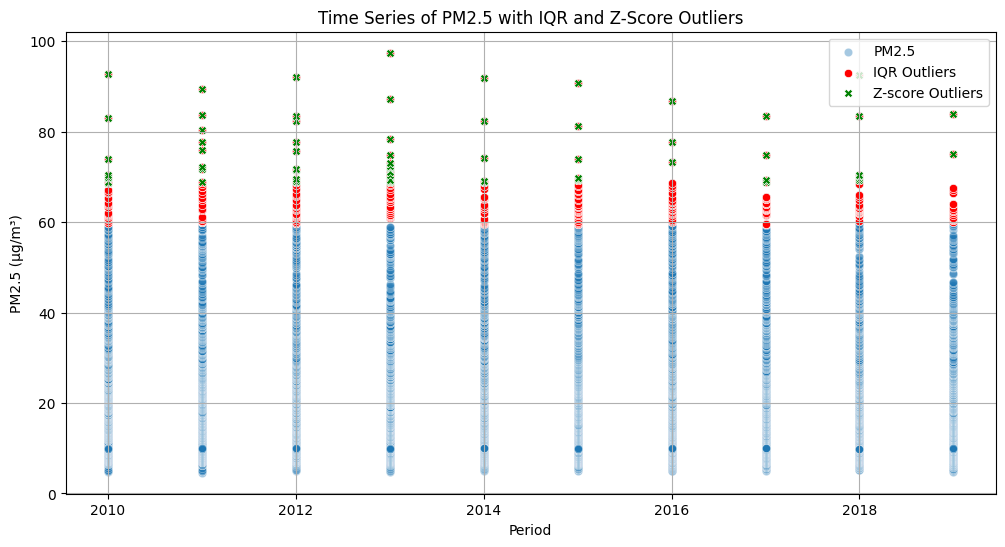

In [26]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Period', y='FactValueNumeric', label='PM2.5', alpha=0.4)

# Overlay IQR outliers in red
sns.scatterplot(data=df[df['outlier_IQR'] == 1], 
                x='Period', y='FactValueNumeric', 
                color='red', label='IQR Outliers')

# Overlay Z-score outliers in green
sns.scatterplot(data=df[df['outlier_z'] == 1], 
                x='Period', y='FactValueNumeric', 
                color='green', label='Z-score Outliers', marker='X')

plt.title('Time Series of PM2.5 with IQR and Z-Score Outliers')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
# Outlier overlap comparison
both = ((df['outlier_IQR'] == 1) & (df['outlier_z'] == 1)).sum()
iqr_only = ((df['outlier_IQR'] == 1) & (df['outlier_z'] == 0)).sum()
z_only = ((df['outlier_IQR'] == 0) & (df['outlier_z'] == 1)).sum()

print(f'Outliers by IQR only: {iqr_only}')
print(f'Outliers by Z-score only: {z_only}')
print(f'Outliers by both methods: {both}')

Outliers by IQR only: 215
Outliers by Z-score only: 0
Outliers by both methods: 66


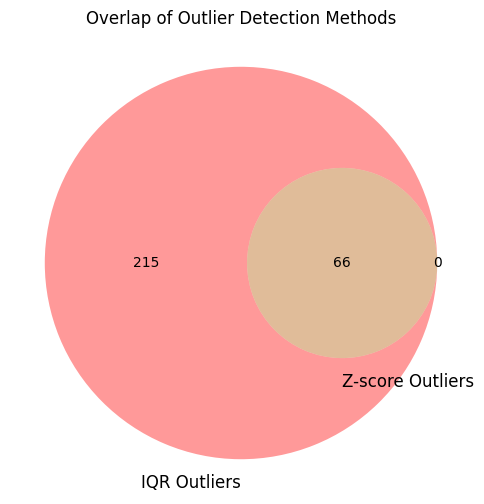

In [28]:
# Get sets of index positions
iqr_set = set(df[df['outlier_IQR'] == 1].index)
zscore_set = set(df[df['outlier_z'] == 1].index)

# Plot the Venn diagram
plt.figure(figsize=(6, 6))
venn2([iqr_set, zscore_set], set_labels=('IQR Outliers', 'Z-score Outliers'))
plt.title('Overlap of Outlier Detection Methods')
plt.show()


In [11]:
# Group by 'Location' (countries) and sum the outliers identified by IQR and Z-score
country_summary = df.groupby('Location')[['outlier_IQR', 'outlier_z']].sum()

# Rename columns to make the output more readable
country_summary.columns = ['IQR Outliers', 'Z-score Outliers']

# Calculate the number of countries with outliers in both methods (IQR and Z-score)
country_summary['Both Methods'] = df.groupby('Location').apply(
    lambda x: ((x['outlier_IQR'] == 1) & (x['outlier_z'] == 1)).sum()
)

# Sort by the number of shared outliers in both methods
country_summary = country_summary.sort_values('Both Methods', ascending=False)

# Display the top 10 countries with the most shared outliers
country_summary.head(10)


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_90311/3715046991.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_summary['Both Methods'] = df.groupby('Location').apply(


,IQR Outliers,Z-score Outliers,Both Methods
Location,,,
Afghanistan,47,28,28
Tajikistan,40,15,15
Kuwait,30,13,13
Mongolia,12,6,6
Democratic People's Republic of Korea,14,3,3
China,5,1,1
Madagascar,0,0,0
Peru,0,0,0
North Macedonia,0,0,0


### 3.4 Cleaning the Outliers using IQR method

In [12]:
# Remove rows with outliers based on IQR method
df = df[(df['FactValueNumeric'] >= lower_bound) & (df['FactValueNumeric'] <= upper_bound)]

## **4. Summary of Changes**
#### After cleaning the data, the dataset was significantly reduced in size due to the removal of outliers. The following table summarizes the changes before and after cleaning:


| Metric                 |  Before Cleaning  | After Cleaning   |
|------------------------|------------------|------------------|
| Total Rows             | 9450             | 9169            |
| Total Columns | 34              | 20             |
| Total Outliers      | 281              | 0                |


In [13]:
# Drop the columns used for outlier detection (IQR, Z-score, and their flags)
df = df.drop(columns=["outlier_IQR", "z_score", "outlier_z"])

In [14]:
# Save the cleaned DataFrame to a CSV file
df.to_csv("../data/processed/pm25_cleaned.csv", index=False)